# 주택 가격 예측 문제
* 보스턴의 주택 가격 데이터 세트를 이용하여 주택 가격을 예측합니다.

In [3]:
import keras
keras.__version__

'2.2.4'

## 보스턴 주택 가격 데이터 세트

* 보스턴 주택 가격 세트를 이용하여 지역 특징이 주어졌을 때 주택 가격의 중간 값을 예측합니다.
* 데이터 세트의 각 특징이 모두 다른 스케일을 가집니다.

In [0]:
from keras.datasets import boston_housing
import numpy as np

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()
np.load = np_load_old

* 데이터 세트는 404개의 훈련 세트와 102개의 테스트 세트가 존재합니다.
* 데이터 세트는 13개의 특징을 가집니다. 13개의 특징은 다음과 같습니다.

1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. % lower status of the population.

## 데이터 가공
* 서로 다른 스케일을 가진 값을 신경망에 주입 하는것은 바람직하지 않습니다.
* 데이터 특성별 정규화를 시행 합니다.
* 입력 데이터에 있는 특성에 대해 특성의 평균을 뺴고 표준편차로 나눕니다.

In [0]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## 회귀 모델 만들기
* 2개의 층을 사용한 작은 신경망을 사용 합니다.
* 마지막 출력은 비선형 함수를 적용하지 않은 단일 출력입니다.

In [0]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## K-겹 검증을 사용한 검증
* 훈련 세트와 검증 세트로 분류합니다.
* 훈련 세트와 검증 세트가 매우 작아 모델을 신뢰성 있게 평가 할 수 없습니다.
* K-겹 교차 검증을 이용하여 모델을 평가 해야 합니다.
* 데이터를 K 개로 나누고, K개의 모델을 만들어 각각의 분할에서 훈련한 뒤 나머지 분할에서 평가 합니다.



In [8]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)

    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]


    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

W0729 13:26:16.684700 140695999907712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 13:26:16.717421 140695999907712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 13:26:16.721426 140695999907712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 13:26:16.768210 140695999907712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



처리중인 폴드 # 0


W0729 13:26:16.931037 140695999907712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0729 13:26:16.940702 140695999907712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [9]:
all_scores

[2.0229690310978654,
 2.2601858554500165,
 2.8769885443224767,
 2.3715506072091586]

In [10]:
np.mean(all_scores)

2.3829235095198795

검증 세트에 따라 다른 값이 나옵니다.
신경망을 오래 훈련하여 더 경과를 지켜봅니다.

In [11]:
from keras import backend as K

K.clear_session()

num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [0]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

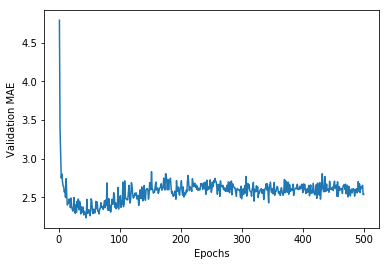

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

그래프를 알아보기 쉽게 재가공 합니다.
* 변동이 매우 심하며 큰 의미를 가지지 않는 첫번째 10개 샘플을 제외합니다.
* 곡선을 부드럽게 만들기 위해 곡선의 포인트를 이전 포인트의 지수 이동 평균으로 대체합니다.

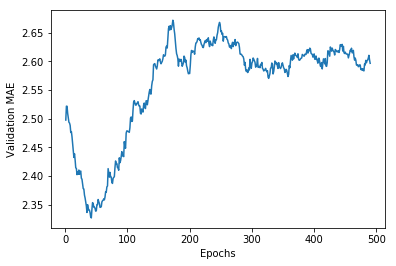

In [14]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

80번째 epoch 이후로 모델의 검증 신뢰도가 떨어지므로, 이 이후를 과대적합으로 볼 수 있습니다. 

모델을 수정하여 최종 모델을 훈련합니다.

In [15]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 940us/step


In [17]:
test_mae_score * 1000

2692.8993954378016